In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification

In [4]:
from gensim.models import Word2Vec

In [5]:
sys.path.append("../scripts/")
from ml_utils import MultiLabelClassification

# Data preprocessing

The lyrics are tokenized, then converted into sequences to generate a zero-padded $n$-by-$m$ feature matrix $X$ where $n$ is the number of songs and $m$ is the maximum token length (word count) among songs.

In [6]:
df = pd.read_csv("../songs-ml-10pct.csv")

In [7]:
df.lyrics.str.split().apply(len).describe()

count    58174.000000
mean       167.738234
std         85.684165
min          1.000000
25%        111.000000
50%        156.000000
75%        210.000000
max       2392.000000
Name: lyrics, dtype: float64

In [8]:
input_length = df.lyrics.str.split().apply(len).max()

In [9]:
for col in df.columns[1:]:
    print(f"{col}: {100*df[col].mean():.2g}%")

black: 17%
death: 34%
heavy: 17%
power: 20%
thrash: 18%


In [10]:
X = df.lyrics.values
y = df[df.columns[1:]].values
num_labels = y.shape[1]
labels = df.columns[1:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Glove pre-trained word embeddings

In [13]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\'')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.index_word) + 1
print(vocab_size)

95700


In [14]:
def texts_to_sequences(texts, maxlen=input_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    return padded

In [15]:
padded_train = texts_to_sequences(X_train)
padded_test = texts_to_sequences(X_test)

In [16]:
padded_train.shape

(46539, 2392)

In [17]:
padded_train

array([[1319,   39,    2, ...,    0,    0,    0],
       [  28,   22,    5, ...,    0,    0,    0],
       [ 744,  384,  919, ...,    0,    0,    0],
       ...,
       [ 138,    1,  892, ...,    0,    0,    0],
       [   3,   54,   22, ...,    0,    0,    0],
       [   3,  463,  646, ...,    0,    0,    0]])

### Resize sequences to a more manageable length

In [18]:
def resize_sequences(X_old, y_old, length):
    X_new = []
    y_new = []
    for i, row in enumerate(X_old):
        new_rows = np.split(row, np.arange(0, len(row), length))[1:]
        for new_row in new_rows:
            new_row_padded = np.pad(new_row, (0, input_length_short - len(new_row)))
            if sum(new_row_padded) > 0:
                X_new.append(new_row_padded)
                y_new.append(y_old[i])
    X_new = np.array(X_new)
    y_new = np.array(y_new)
    return X_new, y_new

In [19]:
input_length_short = 100
padded_train, y_train = resize_sequences(padded_train, y_train, input_length_short)
padded_test, y_test = resize_sequences(padded_test, y_test, input_length_short)

In [20]:
print(padded_train.shape, y_train.shape, padded_test.shape, y_test.shape)

(103199, 100) (103199, 5) (25751, 100) (25751, 5)


In [33]:
label_weights = 1 / y_train.sum(axis=0)
label_weights /= label_weights.sum()
print(label_weights)

sample_weights = (y_train * label_weights).mean(axis=1)
sample_weights[sample_weights == 0] = sample_weights.mean()
for i in range(20):
    print(y_train[i], sample_weights[i])

[0.25537839 0.12325381 0.22555379 0.17446309 0.22135093]
[0 1 0 0 0] 0.024650761659075756
[0 1 0 0 0] 0.024650761659075756
[0 1 0 0 0] 0.024650761659075756
[0 1 0 0 1] 0.06892094669423254
[0 1 0 0 1] 0.06892094669423254
[0 1 0 0 1] 0.06892094669423254
[0 0 0 1 0] 0.03489261742479792
[0 0 0 1 0] 0.03489261742479792
[1 1 0 0 0] 0.07572643937130955
[1 1 0 0 0] 0.07572643937130955
[1 1 0 0 0] 0.07572643937130955
[1 0 0 0 0] 0.05107567771223379
[1 0 0 0 0] 0.05107567771223379
[0 1 0 0 0] 0.024650761659075756
[0 1 0 0 0] 0.024650761659075756
[0 0 0 0 0] 0.039712714073097996
[1 1 0 0 0] 0.07572643937130955
[1 1 0 0 0] 0.07572643937130955
[0 0 0 0 0] 0.039712714073097996
[1 0 0 0 0] 0.05107567771223379


### Load word vectors into a dictionary

Adapted from [a Keras tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/).

In [21]:
# path_to_glove_file = "E:/Projects/metallyrics/data/glove.840B.300d.txt"
path_to_glove_file = "E:/Projects/metallyrics/data/glove.6B.100d.txt"

embedding_vectors = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_vectors[word] = coefs
print(len(embedding_vectors))
print(len(list(embedding_vectors.values())[0]))

400001
100


### Embedding matrix

In [22]:
embedding_dim = len(list(embedding_vectors.values())[0])
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) > 0:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
            continue
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 52969 words (42730 misses)


In [23]:
embedding_matrix.shape

(95700, 100)

In [24]:
embedding_layer = layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Word replacement

In [25]:
vector = embedding_vectors['satan']
# dist = np.linalg.norm(embedding_matrix - vector, axis=1)
dist = -np.dot(embedding_matrix, vector)
nearest = [(tokenizer.index_word.get(i, 0), dist[i]) for i in  dist.argsort()[1:11]]
nearest

[('god', -19.013266124371704),
 ('evil', -16.74109671214331),
 ('devil', -16.391001127660708),
 ('jesus', -16.09329618071708),
 ('christ', -16.062787387783878),
 ('sacrifice', -14.433605984472056),
 ('heaven', -14.177968450023208),
 ('witches', -14.173267745378634),
 ('allah', -14.02747231518036),
 ('gods', -14.01646492569156)]

In [26]:
from nltk.corpus import stopwords

In [27]:
ignore = stopwords.words('english')

In [28]:
np.linalg.norm(embedding_matrix, axis=1)

array([0.        , 5.82115365, 6.29686884, ..., 4.74738433, 4.41079049,
       0.        ])

In [29]:
def get_nearest_word(word, method='euclidean'):
    if word not in ignore and isinstance(word, str):
        if word in embedding_vectors.keys():
            vector = embedding_vectors[word]
            if len(vector) > 0:
                if method == 'euclidean':
                    dist = np.linalg.norm(embedding_matrix - vector, axis=1)
                    i = dist.argsort()[1]
                elif method == 'cosine':
                    embedding_norm = np.linalg.norm(embedding_matrix, axis=1)
                    vector_norm = np.linalg.norm(vector)
                    dist = np.dot(embedding_matrix, vector) / (embedding_norm * vector_norm)
                    dist = np.nan_to_num(dist, 0)
                    i = dist.argsort()[-2]
                else:
                    assert ValueError(f"invalid method {method}")
                nearest = tokenizer.index_word.get(i, 0)
                if nearest not in ignore:
                    return nearest
    return word

In [30]:
words = [tokenizer.index_word.get(i, 0) for i in padded_train[111]]
new_words = [get_nearest_word(word, 'cosine') for word in words]
new_row = [tokenizer.word_index.get(word, 0) for word in new_words]
print(words[:20])
print(new_words[:20])

C:\Users\philn\AppData\Local\Temp\ipykernel_2652\3763140851.py:12: RuntimeWarning: invalid value encountered in true_divide
  dist = np.dot(embedding_matrix, vector) / (embedding_norm * vector_norm)


['it’s', 'everything', 'what’s', 'wrong', 'with', 'it', 'it’s', 'everything', 'what’s', 'wrong', 'with', 'us', 'null', 'rictus', 'grin', 'beyond', 'death', 'and', 'it’s', 'after']
['it’s', 'things', 'what’s', 'mistake', 'with', 'it', 'it’s', 'things', 'what’s', 'mistake', 'with', 'us', 'invalid', 'luxuriance', 'smile', 'far', 'died', 'and', 'it’s', 'after']


### Convolution neural network

In [30]:
cnn_model = Sequential()
cnn_model.add(embedding_layer)
cnn_model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
# cnn_model.add(layers.BatchNormalization())
# cnn_model.add(layers.MaxPooling1D(pool_size=2))
# cnn_model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(256))
cnn_model.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         51328     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                        

In [31]:
cnn_history = cnn_model.fit(padded_train, y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 17s 6ms/step - loss: 0.4689 - accuracy: 0.3382 - val_loss: 0.4520 - val_accuracy: 0.3797
Epoch 2/64
2580/2580 [==============================] - 15s 6ms/step - loss: 0.4439 - accuracy: 0.3891 - val_loss: 0.4462 - val_accuracy: 0.3977
Epoch 3/64
2580/2580 [==============================] - 16s 6ms/step - loss: 0.4333 - accuracy: 0.4064 - val_loss: 0.4437 - val_accuracy: 0.4033
Epoch 4/64
2580/2580 [==============================] - 16s 6ms/step - loss: 0.4249 - accuracy: 0.4197 - val_loss: 0.4425 - val_accuracy: 0.4023
Epoch 5/64
2580/2580 [==============================] - 17s 6ms/step - loss: 0.4171 - accuracy: 0.4320 - val_loss: 0.4440 - val_accuracy: 0.3905
Epoch 6/64
2580/2580 [==============================] - 17s 7ms/step - loss: 0.4104 - accuracy: 0.4406 - val_loss: 0.4461 - val_accuracy: 0.3946
Epoch 7/64
2580/2580 [==============================] - 16s 6ms/step - loss: 0.4040 - accuracy: 0.4495 - val_loss: 0.4474 - val_ac

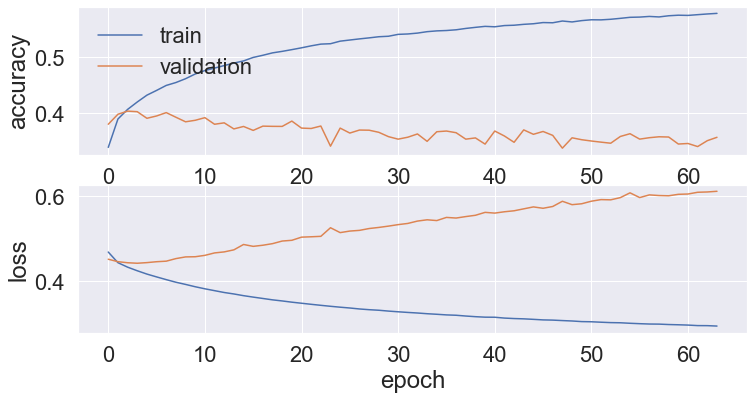

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(cnn_history.history['accuracy'])
ax1.plot(cnn_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(cnn_history.history['loss'])
ax2.plot(cnn_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

In [33]:
cnn_pred.round().astype(int)[:20]

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0]])

In [34]:
y_test[:20]

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

### LSTM

In [35]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(layers.SpatialDropout1D(0.2))
lstm_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                      

In [36]:
lstm_history = lstm_model.fit(padded_train, y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=1)
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 125s 48ms/step - loss: 0.4844 - accuracy: 0.3388 - val_loss: 0.4449 - val_accuracy: 0.3795
Epoch 2/64
2580/2580 [==============================] - 131s 51ms/step - loss: 0.4490 - accuracy: 0.3805 - val_loss: 0.4387 - val_accuracy: 0.3953
Epoch 3/64
2580/2580 [==============================] - 134s 52ms/step - loss: 0.4407 - accuracy: 0.3966 - val_loss: 0.4341 - val_accuracy: 0.3836
Epoch 4/64
2580/2580 [==============================] - 150s 58ms/step - loss: 0.4338 - accuracy: 0.4062 - val_loss: 0.4321 - val_accuracy: 0.4125
Epoch 5/64
2580/2580 [==============================] - 156s 60ms/step - loss: 0.4285 - accuracy: 0.4133 - val_loss: 0.4297 - val_accuracy: 0.4173
Epoch 6/64
2580/2580 [==============================] - 176s 68ms/step - loss: 0.4239 - accuracy: 0.4194 - val_loss: 0.4283 - val_accuracy: 0.4162
Epoch 7/64
2580/2580 [==============================] - 172s 67ms/step - loss: 0.4196 - accuracy: 0.4248 - val_loss: 0

KeyboardInterrupt: 

In [40]:
lstm_model = model
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

loss: 0.4437
acc: 0.4171


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(lstm_history.history['accuracy'])
ax1.plot(lstm_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(lstm_history.history['loss'])
ax2.plot(lstm_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()


Average binary classification scores:
  balanced_accuracy   0.62 +/- 0.07
  precision           0.57 +/- 0.09
  recall              0.31 +/- 0.23
  f1                  0.39 +/- 0.20

Multi-label classification metrics:
  accuracy      0.31
  precision     0.58
  recall        0.36
  f1            0.44
  hamming loss  0.98

ROC AUC scores:
  black     : 0.802
  death     : 0.754
  heavy     : 0.772
  power     : 0.785
  thrash    : 0.707
  macro-avg : 0.764 +/- 0.033


array([0.11514997, 0.36893153, 0.14259663, 0.19652411, 0.16775662])

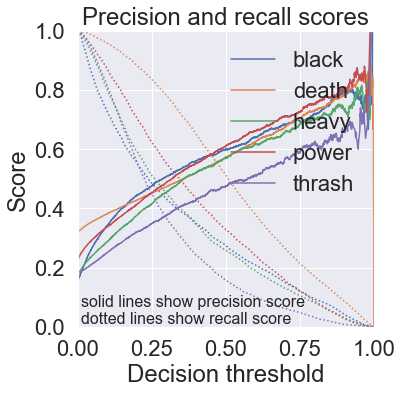

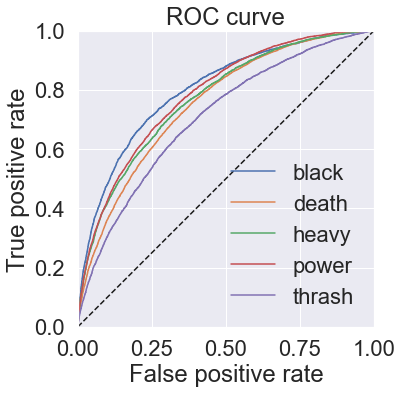

In [43]:
lstm_mlc = MultiLabelClassification(y_test, pred=lstm_pred, labels=labels)
lstm_mlc.print_report()
lstm_mlc.plot_precision_recall_curve()
lstm_mlc.plot_roc_curve()
lstm_mlc.best_thresholds()

In [44]:
lstm_mlc_tuned = MultiLabelClassification(y_test, pred=lstm_pred, labels=labels, threshold=lstm_mlc.best_thresholds())
lstm_mlc_tuned.print_report()


Average binary classification scores:
  balanced_accuracy   0.70 +/- 0.05
  precision           0.38 +/- 0.14
  recall              0.69 +/- 0.05
  f1                  0.49 +/- 0.12

Multi-label classification metrics:
  accuracy      0.38
  precision     0.41
  recall        0.71
  f1            0.52
  hamming loss  1.50

ROC AUC scores:
  black     : 0.802
  death     : 0.754
  heavy     : 0.772
  power     : 0.785
  thrash    : 0.707
  macro-avg : 0.764 +/- 0.033


In [45]:
lstm_pred.round().astype(int)[:20]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0]])

In [46]:
lstm_mlc_tuned.pred_class[:20]

array([[1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0]])

In [47]:
y_test[:20]

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

### LSTM trained with sample weights

In [51]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [54]:
lstm_model_2 = Sequential()
lstm_model_2.add(embedding_layer)
lstm_model_2.add(layers.SpatialDropout1D(0.2))
lstm_model_2.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
lstm_model_2.add(layers.Dropout(0.2))
lstm_model_2.add(layers.BatchNormalization())
lstm_model_2.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.1)
lstm_model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [55]:
lstm_2_history = lstm_model_2.fit(
    padded_train,
    y_train,
    sample_weight=sample_weights,
    epochs=64,
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1
)
lstm_2_pred = lstm_model_2.predict(padded_test)
lstm_2_loss, lstm_2_acc = lstm_model_2.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_2_loss:.4f}\nacc: {lstm_2_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 152s 58ms/step - loss: 0.0291 - accuracy: 0.2020 - val_loss: 0.0270 - val_accuracy: 0.2774
Epoch 2/64
2580/2580 [==============================] - 147s 57ms/step - loss: nan - accuracy: 0.2433 - val_loss: nan - val_accuracy: 0.3233
Epoch 3/64
2580/2580 [==============================] - 147s 57ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 4/64
2580/2580 [==============================] - 159s 62ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 5/64
2580/2580 [==============================] - 162s 63ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 6/64
2580/2580 [==============================] - 172s 66ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 7/64
2580/2580 [==============================] - 173s 67ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 8

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(lstm_2_history.history['accuracy'])
ax1.plot(lstm_2_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(lstm_2_history.history['loss'])
ax2.plot(lstm_2_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

In [ ]:
lstm_2_mlc = MultiLabelClassification(y_test, pred=lstm_2_pred, labels=labels)
lstm_2_mlc.print_report()
lstm_2_mlc.plot_precision_recall_curve()
lstm_2_mlc.plot_roc_curve()
lstm_2_mlc.best_thresholds()

In [ ]:
lstm_2_mlc_tuned = MultiLabelClassification(y_test, pred=lstm_2_pred, labels=labels, threshold=lstm_2_mlc.best_thresholds())
lstm_2_mlc_tuned.print_report()

In [ ]:
lstm_2_pred.round().astype(int)[:20]

In [ ]:
lstm_2_mlc_tuned.pred_class[:20]

In [ ]:
y_test[:20]